In [1]:
import sys
import torch
import numpy as np
import pandas as pd
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt


In [2]:
# set random seed
torch.manual_seed(1)
np.random.seed(1)

In [3]:
# import custom modules
from utils.flutil import Flutils as flutils
from utils.modelutil import ModelUtils as modelutils
from utils.modelutil import FashionMNISTCNN

In [4]:
model_global = FashionMNISTCNN()

In [5]:
# print model architecture
print(model_global)

FashionMNISTCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


In [6]:
layer_name = "fc.weight"
global_params = model_global.state_dict()[layer_name]

In [7]:
global_params.shape

torch.Size([10, 1568])

In [8]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [9]:
# Model training constants
batch_size = 32
lr = 1e-3
num_epochs = 2


# FL constants
num_clients = 50
num_malicious = 10
rounds = 5
defend_model = True

In [10]:
# Prepare attacks
clients_attack = [False for _ in range(num_clients)]

# Randomly select malicious clients
malicious_clients = np.random.choice(num_clients, num_malicious, replace=False)
for i in malicious_clients:
    clients_attack[i] = True

In [11]:
print(f"Malicious clients: {malicious_clients}")

Malicious clients: [27 35 40 38  2  3 48 29 46 31]


In [12]:
clients_attack

[False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False]

In [13]:
# Load data
trainset, testset, trainloader, testloader = modelutils.load_data(batch_size=batch_size)

# prepare clients train loader
trainset_split = random_split(trainset, [int(len(trainset) / num_clients) for _ in range(num_clients)])
client_trainloaders = [DataLoader(x, batch_size=batch_size, shuffle=True) for x in trainset_split]

--> client 0 trained, round 0 	 final loss: 0.71

--> client 1 trained, round 0 	 final loss: 0.717

--> client 2 trained, round 0 	 final loss: 2.437

--> client 3 trained, round 0 	 final loss: 2.446

--> client 4 trained, round 0 	 final loss: 0.677

--> client 5 trained, round 0 	 final loss: 0.651

--> client 6 trained, round 0 	 final loss: 0.69

--> client 7 trained, round 0 	 final loss: 0.681

--> client 8 trained, round 0 	 final loss: 0.712

--> client 9 trained, round 0 	 final loss: 0.674

--> client 10 trained, round 0 	 final loss: 0.683

--> client 11 trained, round 0 	 final loss: 0.704

--> client 12 trained, round 0 	 final loss: 0.669

--> client 13 trained, round 0 	 final loss: 0.691

--> client 14 trained, round 0 	 final loss: 0.652

--> client 15 trained, round 0 	 final loss: 0.661

--> client 16 trained, round 0 	 final loss: 0.694

--> client 17 trained, round 0 	 final loss: 0.703

--> client 18 trained, round 0 	 final loss: 0.709

--> client 19 trained, r

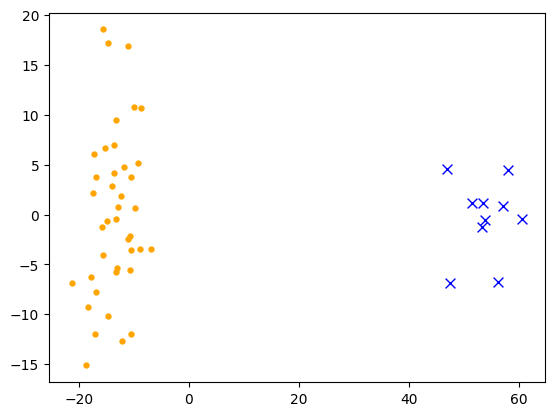

--> client 0 trained, round 1 	 final loss: 0.562

--> client 1 trained, round 1 	 final loss: 0.582

--> client 2 trained, round 1 	 final loss: 2.424

--> client 3 trained, round 1 	 final loss: 2.401

--> client 4 trained, round 1 	 final loss: 0.569

--> client 5 trained, round 1 	 final loss: 0.529

--> client 6 trained, round 1 	 final loss: 0.546

--> client 7 trained, round 1 	 final loss: 0.522

--> client 8 trained, round 1 	 final loss: 0.561

--> client 9 trained, round 1 	 final loss: 0.569

--> client 10 trained, round 1 	 final loss: 0.534

--> client 11 trained, round 1 	 final loss: 0.547

--> client 12 trained, round 1 	 final loss: 0.531

--> client 13 trained, round 1 	 final loss: 0.577

--> client 14 trained, round 1 	 final loss: 0.516

--> client 15 trained, round 1 	 final loss: 0.52

--> client 16 trained, round 1 	 final loss: 0.566

--> client 17 trained, round 1 	 final loss: 0.575

--> client 18 trained, round 1 	 final loss: 0.558

--> client 19 trained, 

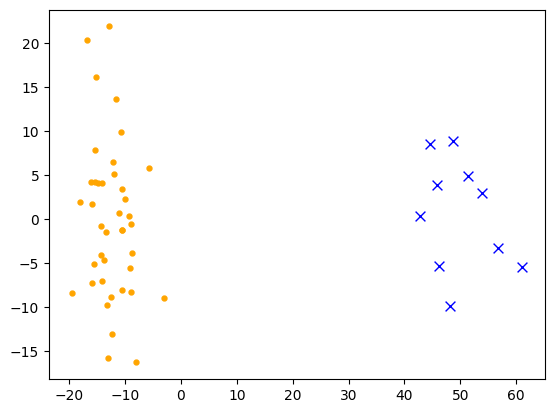

--> client 0 trained, round 2 	 final loss: 0.508

--> client 1 trained, round 2 	 final loss: 0.522

--> client 2 trained, round 2 	 final loss: 2.42

--> client 3 trained, round 2 	 final loss: 2.422

--> client 4 trained, round 2 	 final loss: 0.479

--> client 5 trained, round 2 	 final loss: 0.453

--> client 6 trained, round 2 	 final loss: 0.482

--> client 7 trained, round 2 	 final loss: 0.464

--> client 8 trained, round 2 	 final loss: 0.493

--> client 9 trained, round 2 	 final loss: 0.489

--> client 10 trained, round 2 	 final loss: 0.482

--> client 11 trained, round 2 	 final loss: 0.479

--> client 12 trained, round 2 	 final loss: 0.482

--> client 13 trained, round 2 	 final loss: 0.541

--> client 14 trained, round 2 	 final loss: 0.476

--> client 15 trained, round 2 	 final loss: 0.469

--> client 16 trained, round 2 	 final loss: 0.491

--> client 17 trained, round 2 	 final loss: 0.507

--> client 18 trained, round 2 	 final loss: 0.512

--> client 19 trained, 

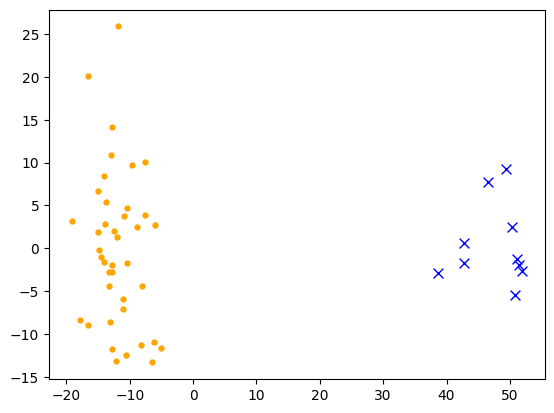

--> client 0 trained, round 3 	 final loss: 0.486

--> client 1 trained, round 3 	 final loss: 0.48

--> client 2 trained, round 3 	 final loss: 2.439

--> client 3 trained, round 3 	 final loss: 2.412

--> client 4 trained, round 3 	 final loss: 0.445

--> client 5 trained, round 3 	 final loss: 0.416

--> client 6 trained, round 3 	 final loss: 0.466

--> client 7 trained, round 3 	 final loss: 0.466

--> client 8 trained, round 3 	 final loss: 0.452

--> client 9 trained, round 3 	 final loss: 0.455

--> client 10 trained, round 3 	 final loss: 0.446

--> client 11 trained, round 3 	 final loss: 0.448

--> client 12 trained, round 3 	 final loss: 0.43

--> client 13 trained, round 3 	 final loss: 0.467

--> client 14 trained, round 3 	 final loss: 0.42

--> client 15 trained, round 3 	 final loss: 0.41

--> client 16 trained, round 3 	 final loss: 0.45

--> client 17 trained, round 3 	 final loss: 0.464

--> client 18 trained, round 3 	 final loss: 0.47

--> client 19 trained, round

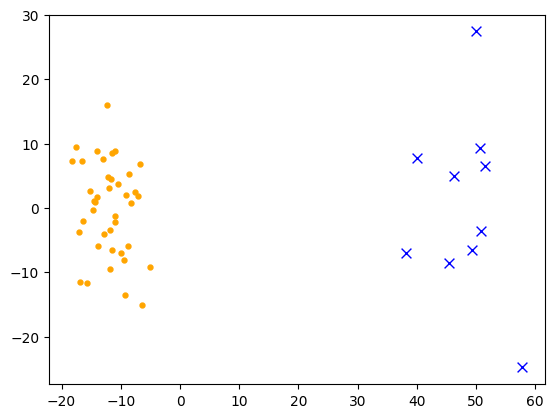

--> client 0 trained, round 4 	 final loss: 0.438

--> client 1 trained, round 4 	 final loss: 0.449

--> client 2 trained, round 4 	 final loss: 2.46

--> client 3 trained, round 4 	 final loss: 2.454

--> client 4 trained, round 4 	 final loss: 0.395

--> client 5 trained, round 4 	 final loss: 0.403

--> client 6 trained, round 4 	 final loss: 0.437

--> client 7 trained, round 4 	 final loss: 0.401

--> client 8 trained, round 4 	 final loss: 0.419

--> client 9 trained, round 4 	 final loss: 0.44

--> client 10 trained, round 4 	 final loss: 0.403

--> client 11 trained, round 4 	 final loss: 0.422

--> client 12 trained, round 4 	 final loss: 0.436

--> client 13 trained, round 4 	 final loss: 0.443

--> client 14 trained, round 4 	 final loss: 0.418

--> client 15 trained, round 4 	 final loss: 0.399

--> client 16 trained, round 4 	 final loss: 0.434

--> client 17 trained, round 4 	 final loss: 0.436

--> client 18 trained, round 4 	 final loss: 0.431

--> client 19 trained, r

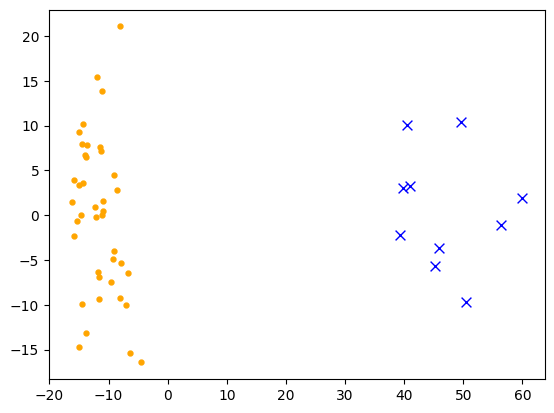

<Figure size 640x480 with 0 Axes>

In [14]:
train_losses = []
model_test_acc  = []
model_global = FashionMNISTCNN()
# list of list to collect the loss of each clients
clients_loss = [[] for _ in range(num_clients)]
for r in range(rounds):
    round_loss = 0.0
    client_models = []
    for i in range(num_clients):
        # create a model
        model = FashionMNISTCNN()
        model.to(device)
        # Train Loader
        trainloader = client_trainloaders[i]
        model.load_state_dict(model_global.state_dict())

        # Define optimizer and loss
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        
        loss = modelutils.modelTrainer(
            model=model, 
            num_epochs=num_epochs, 
            trainloader=trainloader, 
            optimizer=optimizer, 
            criterion=criterion,  
            device=device, 
            attack=clients_attack[i])[-1]
        client_models.append(model)
        round_loss += loss
        clients_loss[i].append(loss)
        print(f"--> client {i} trained, round {r} \t final loss: {round(loss, 3)}\n")
    train_losses.append(round_loss / num_clients)
    model_global.load_state_dict(flutils.aggregateModel(client_models, model_global, defend_model))
    model_test_acc.append(modelutils.test_total_accuracy(model_global, testloader, device))   

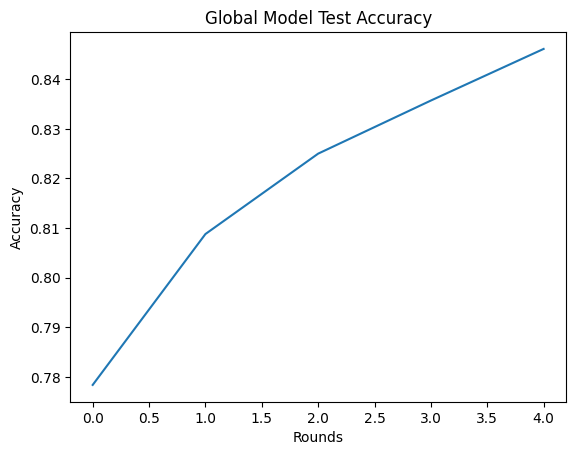

In [15]:
# plot model_test_acc
plt.plot(model_test_acc)
plt.title("Global Model Test Accuracy")
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.show()

Text(0, 0.5, 'Loss')

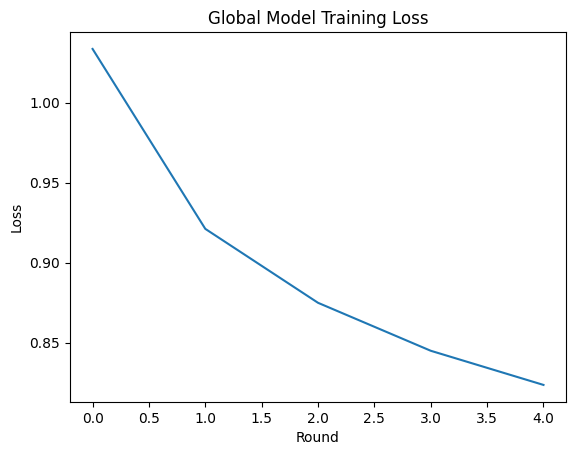

In [16]:
# print and plot training losses for the global model
plt.plot(train_losses)
plt.title("Global Model Training Loss")
plt.xlabel("Round")
plt.ylabel("Loss")

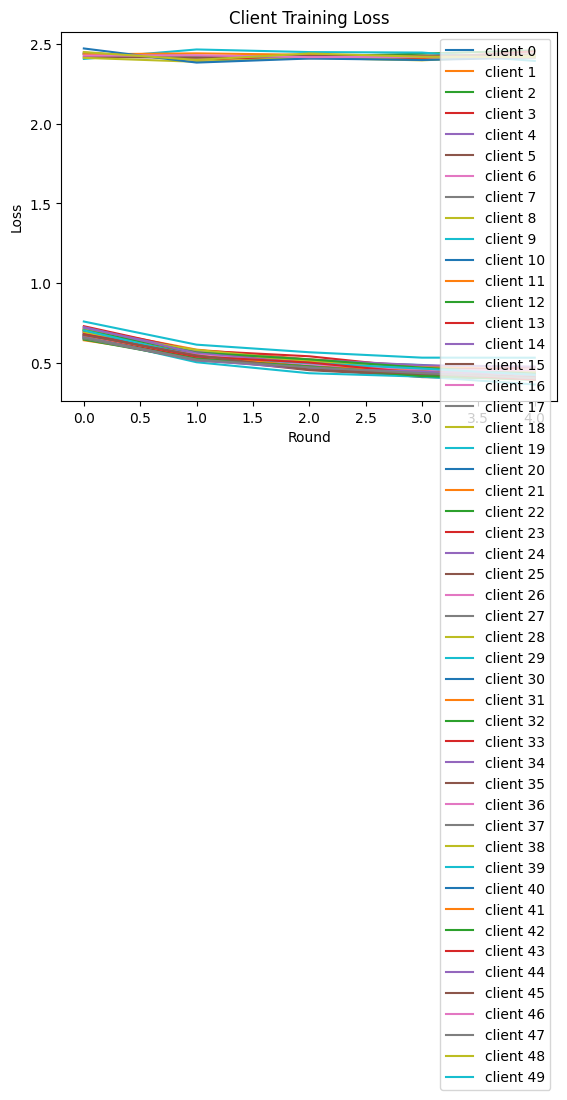

In [17]:
# Plot the loss of each client
for i in range(num_clients):
    plt.plot(clients_loss[i])
    plt.title("Client Training Loss")
    plt.xlabel("Round")
    plt.ylabel("Loss")
plt.legend([f"client {i}" for i in range(num_clients)])
plt.show()